## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from Constants import *

In [2]:
import midi

# Translates numpy arrays into midi files
def data_to_midi(data, bpm=60):

    SCALER = 4 # Aribtrary value to round up the PPQN and not lose accuracy
    PPQN = FRAME_RATE*SCALER # Pulses per quarter note

    pattern = midi.Pattern(resolution=round(PPQN))
    track = midi.Track()
    tempo_event = midi.events.SetTempoEvent()
    tempo_event.set_bpm(bpm)
    track.append(tempo_event)

    note_array = np.zeros(N_NOTES, dtype=int)
    num_pitches, num_frames = data.shape
    track.make_ticks_abs()
    for t in range(num_frames):
        for pitch in range(num_pitches):
            pressed = data[pitch][t]
            if pressed == 1 and note_array[pitch] == 0:
                track.append(midi.NoteOnEvent(tick=t*SCALER, pitch=pitch+FMIN_MIDI_INDEX, velocity=64))
                note_array[pitch] = 1
            elif pressed == 0 and note_array[pitch] == 1:
                track.append(midi.NoteOnEvent(tick=t*SCALER, pitch=pitch+FMIN_MIDI_INDEX, velocity=0))
                note_array[pitch] = 0
    track.append(midi.EndOfTrackEvent(tick=t*SCALER))
    track.make_ticks_rel()

    pattern.append(track)
    return pattern

# Removes any notes shorter than the minimal length, and fills in any rests shorter than the minimal length
def post_process(y, min_note_len, min_rest_len =-1):
    y = y.copy()
    # Loop over every note value
    for i in range(y.shape[0]-1):
        rest_count = 0
        note_count = 0
        if y[i,0] == 0: 
            counting_rests = True
        else:
            counting_rests = False
        # Loop over every frame
        for j in range(y.shape[1]):
            # If the preceeding and the current event is a rest, keep counting rests
            if y[i, j] == 0 and (counting_rests == True or j + 1 < min_rest_len):
                counting_rests = True
                rest_count = rest_count + 1
            # If the preceeding and the current event is a note, keep counting notes
            elif y[i, j] == 1 and (counting_rests == False or j + 1 < min_note_len):
                counting_rests = False
                note_count = note_count + 1
            elif y[i, j] == 0:
                counting_rests = True
                # If it is a first rest, and the amount of notes preceeding it is too little
                if note_count < min_note_len:
                    y[i, j - note_count : j] = 0
                    rest_count = rest_count + note_count + 1
                    note_count = 0
                # If it is a first rest, and the amount of notes preceeding it is long enough
                else:
                    rest_count = 1
            elif y[i, j] == 1:
                counting_rests = False
                # If it is a note note, and the amount of rests preceeding it is too little
                if rest_count < min_rest_len:
                    y[i,j - rest_count : j] = 1
                    note_count = note_count + rest_count + 1
                    rest_count = 0
                # If it is a first note, and the amount of rests preceeding it is long enough
                else:
                    note_count = 1
    return y

## Model loading

In [3]:
model = models.load_model('DNN_training_lr3_hd1_50/model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              271360    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 88)                22616     
                                                                 
Total params: 556,376
Trainable params: 556,376
Non-trainable params: 0
_________________________________________________________________


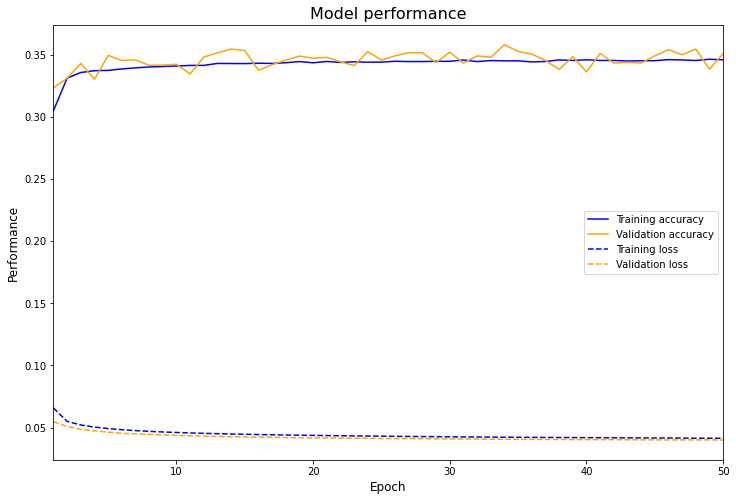

In [4]:
history = np.load('DNN_training_lr3_hd1_50/history.npy', allow_pickle='TRUE').item()

fig = plt.figure(figsize=(12,8))
xrange = np.arange(len(history['accuracy'])) + 1
plt.plot(xrange, history['accuracy'], color='b', linestyle='-')
plt.plot(xrange, history['val_accuracy'], color='orange', linestyle='-')
plt.plot(xrange, history['loss'], color='b', linestyle='--')
plt.plot(xrange, history['val_loss'], color='orange', linestyle='--')
plt.title('Model performance', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.xlim(1, len(xrange))
# plt.ylim(0, 1)
plt.legend(['Training accuracy', 'Validation accuracy', 'Training loss', 'Validation loss'], loc='center right', fontsize=10)
plt.show()

## Prediction

In [5]:
# We load an already preprocessed test file
filename = "2303"
x_test = np.load(PATH_DATA+filename+".npy" ).transpose()
y_test = np.load(PATH_LABELS+filename+".npy" )

print("Data shape: ", x_test.shape)
print("Labels shape: ", y_test.shape)
print("Duration (s): ", x_test.shape[0]*FRAME_LENGTH)

model.evaluate(x_test, y_test)

Data shape:  (2896, 264)
Labels shape:  (2896, 88)
Duration (s):  92.672
91/91 [==============================] - 3s 6ms/step - loss: 0.0315 - accuracy: 0.4838


[0.03152143210172653, 0.4837707281112671]

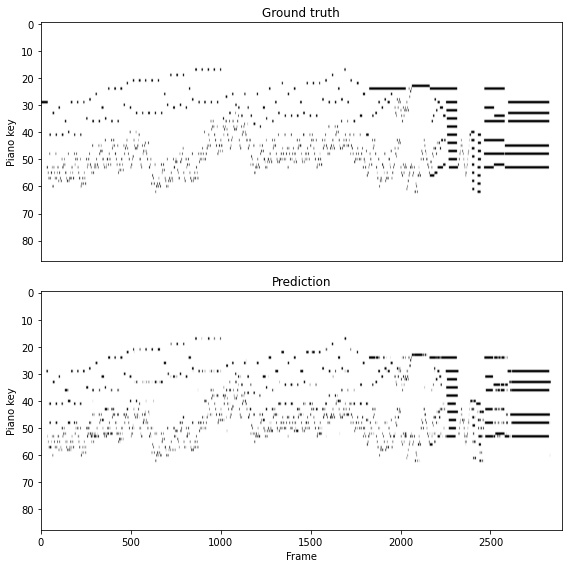

In [7]:
ground_truth = y_test.transpose()
prediction = model.predict(x_test).round().transpose()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

ax1.imshow(ground_truth,cmap='Greys',aspect='auto')
ax1.set_title('Ground truth')
ax1.set_ylabel('Piano key')
ax1.axes.xaxis.set_visible(False)

ax2.imshow(prediction,cmap='Greys',aspect='auto')
ax2.set_title('Prediction')
ax2.set_xlabel('Frame')
ax2.set_ylabel('Piano key')

fig.tight_layout()

C:\Users\Zoilo\AppData\Local\Temp/ipykernel_11184/879208272.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.axes.set_xticklabels([int(x+start_frame) for x in ax1.axes.get_xticks()])


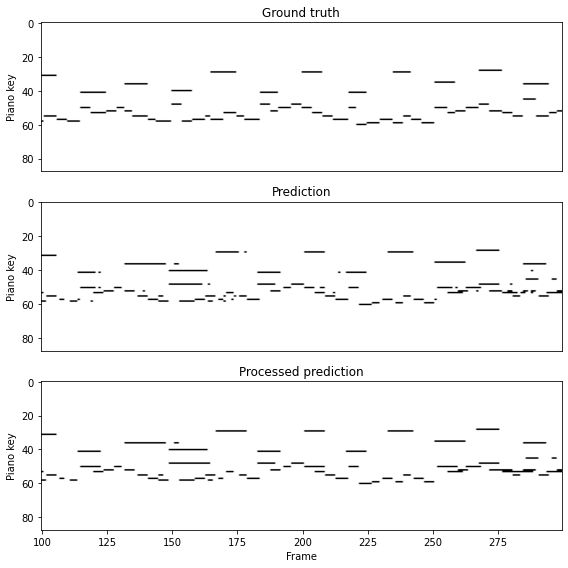

In [8]:
processed_prediction = post_process(prediction,2,3)
start_frame = 100
end_frame = 300

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,8))

ax1.imshow(ground_truth[:,start_frame:end_frame],cmap='Greys',aspect='auto')
ax1.set_title('Ground truth')
ax1.set_ylabel('Piano key')
ax1.axes.xaxis.set_visible(False)

ax2.imshow(prediction[:,start_frame:end_frame],cmap='Greys',aspect='auto')
ax2.set_title('Prediction')
ax2.set_ylabel('Piano key')
ax2.axes.xaxis.set_visible(False)

ax3.imshow(processed_prediction[:,start_frame:end_frame],cmap='Greys',aspect='auto')
ax3.set_title('Processed prediction')
ax3.set_xlabel('Frame')
ax3.set_ylabel('Piano key')
ax3.axes.set_xticklabels([int(x+start_frame) for x in ax1.axes.get_xticks()])

fig.tight_layout()

In [9]:
midi_pattern = data_to_midi(prediction)
midi.write_midifile(filename+'_midi.mid', midi_pattern)

midi_pattern_processed = data_to_midi(processed_prediction)
midi.write_midifile(filename+'_processed_midi.mid', midi_pattern_processed)